# Fortsatt modellering i jakten på de sista tusendelarna accuracy

Nu är jag riktigt nära med 0.9916 i accuracy och kanske nära gränsen för vad som är möjligt med de sämsta bilderna i underlaget. 

Men lite till kan vi försöka hitta.


## Importera nödvändiga paket.

In [7]:
# Av eget intresse vill jag gärna veta hur lång tid olika saker tar.
import time
notebook_start = time.time()  
t0 = time.time()

# Paket för datahantering
import numpy as np
import pandas as pd

# Dataset och modeller
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split #, GridSearchCV, cross_val_score

# Preprocessing/pipeline
# from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# from sklearn.base import clone

# Dimensionsreducering
from sklearn.decomposition import PCA

# Feature-bearbetning
# from skimage.feature import hog

# Data augmentation och förbehandling - stabil version för SciPy
import scipy.ndimage as ndimage

# Modeller 
from sklearn.svm import SVC
# from sklearn.ensemble import ExtraTreesClassifier
# from lightgbm import LGBMClassifier

# Voting för extra "drag" under galoscherna
# from sklearn.ensemble import VotingClassifier

# För export av modellen/scalern för vidare användning i Streamlit-appen
import joblib

# Slutrapport
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

>>> Tid för denna cell: 0.0 sekunder
>>> Total tid sedan start: 0 minuter och 0 sekunder


## Läs in MNISt-datasetet och splitta det. 

*//Best practice: splitta ut testsetet direkt//*

* Ingen standardscaler. Delar med 255.0 för att boosta hanteringen och resultatet. 

In [2]:
t0 = time.time()

# Läs in alla MNIST-data
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False, parser='auto')
X = mnist["data"]              
y = mnist["target"].astype(np.uint8)

# Splitta (80/20) med stratifiering för jämna klassfördelningar
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Normalisering (en riktigt bra grej för både PCA och SVC!)
# Genom att dela med 255.0 blir alla värden mellan 0 och 1
X_train = X_train / 255.0
X_test = X_test / 255.0

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

Hämtar MNIST-data...
----------------------------------------
Data inläst och förberedd: 56000 träningsbilder
>>> Tid för denna cell: 3.2 sekunder
>>> Total tid sedan start: 0 minuter och 5 sekunder


# Augmentation av data

Det här är en mycket värdefull - om än tidskrävande - åtgärd. 

Genom att försiktigt manipulera grundbilderna får jag bättre underlag och ett betydligt större dataset att träna modellen på. 

Det här är en ganska avancerad matematik och jag får erkänna att jag tagit mycket hjälp med detta. 

Mina 25 poäng högskolematematik från 1980- och 1990-talet hjälpte i alla fall till med förståelsen av vad som händer.  

In [9]:
t0 = time.time()

def deskew(image):
    # Räta upp lutande siffror 
    img = image.reshape(28, 28)
    
    # Skapa koordinat-matriser (y för rader, x för kolumner)
    y, x = np.mgrid[:28, :28]
    
    # Hitta tyngdpunkten (Center of Mass) med ndimage
    mu = ndimage.center_of_mass(img)
    if np.isnan(mu).any(): # Om bilden är tom
        return img.flatten()
    
    # Beräkna centrala moments (mu11 = kovarians, mu02 = varians i y-led)
    mu11 = np.sum((x - mu[1]) * (y - mu[0]) * img)
    mu02 = np.sum((y - mu[0])**2 * img)
    
    # Om variansen är för liten lutar siffran inte eller är för tunn
    if abs(mu02) < 1e-2:
        return img.flatten()
    
    # Skew-faktorn (förskjutning av x per enhet y)
    skew = mu11 / mu02
    
    # Här rätas x upp genom subtrahering av skew * y
    # Matrisen blir [[1, 0], [skew, 1]] med SciPys omvända ordning.
    matrix = np.array([[1, 0], [skew, 1]])
    
    # Offset för att rotera/skeva kring bildens centrum (14, 14)
    center = np.array([14, 14])
    offset = center - np.dot(matrix, center)
    
    # Transformation
    img_deskewed = ndimage.affine_transform(img, matrix, offset=offset, order=1, mode='constant', cval=0)
    return img_deskewed.flatten()

def shift_image(image, dx, dy):
    return ndimage.shift(image.reshape(28, 28), [dy, dx], cval=0, mode="constant").flatten()

def rotate_image(image, angle):
    return ndimage.rotate(image.reshape(28, 28), angle, reshape=False, cval=0, mode="constant").flatten()

def zoom_image(image, factor):
    rescaled = ndimage.zoom(image.reshape(28, 28), factor)
    if factor > 1.0: # Zooma in (klipp)
        start = int((rescaled.shape[0] - 28) / 2)
        final = rescaled[start:start+28, start:start+28]
    else: # Zooma ut (padda)
        pad = int((28 - rescaled.shape[0]) / 2)
        final = np.pad(rescaled, ((pad, 28-rescaled.shape[0]-pad), (pad, 28-rescaled.shape[1]-pad)), mode='constant')
    return final.flatten()

# Nu kör vi!
X_train_deskewed = np.array([deskew(img) for img in X_train])

X_train_augmented = [image for image in X_train_deskewed]
y_train_augmented = [label for label in y_train]

# Det blir en riktig boost med ultra-augmentering och 10 varianter per bild.
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train_deskewed, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

for angle in (-12, -8, 8, 12):
    for image, label in zip(X_train_deskewed, y_train):
        X_train_augmented.append(rotate_image(image, angle))
        y_train_augmented.append(label)

for factor in (0.9, 1.1):
    for image, label in zip(X_train_deskewed, y_train):
        X_train_augmented.append(zoom_image(image, factor))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f"Ny datamängd: {len(X_train_augmented)} rader")
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

Steg A: Rätar upp (deskew) originaldatan...
Steg B: Skapar 560 000 extra bilder (Shift, Rotate, Zoom)...
----------------------------------------
Total mängd data för nattkörning: 616000 rader
>>> Tid för denna cell: 43.2 sekunder
>>> Total tid sedan start: 3 minuter och 46 sekunder


## PCA-analys för dimensionsreducering

In [10]:
t0 = time.time()

# Vi kör PCA på de upprätade bilderna (X_train_deskewed, 56 000 rader)
# Det räcker att analysera dessa för att hitta rätt antal komponenter.
pca_analysis = PCA()
pca_analysis.fit(X_train_deskewed)

# Beräkna kumulativ förklarad varians
cumsum = np.cumsum(pca_analysis.explained_variance_ratio_)

# Hitta brytpunkterna för 95% och 99%
d_95 = np.argmax(cumsum >= 0.95) + 1
d_99 = np.argmax(cumsum >= 0.99) + 1

print(f"Antal komponenter för 95% varians (Deskewed data): {d_95}")
print(f"Antal komponenter för 99% varians (Deskewed data): {d_99}")
print("Antal utan augmenteringen: 95 komponenter")

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

Antal komponenter för 95% varians (Deskewed data): 112
Antal komponenter för 99% varians (Deskewed data): 262
Din tidigare inställning var: 95 komponenter
----------------------------------------
>>> Tid för denna cell: 0.6 sekunder
>>> Total tid sedan start: 3 minuter och 52 sekunder


Jag får preparera testsetet så att jämförelsen blir rättvis. Här är en riktig "fuling" där jag av misstag körde mot testsetet istf mina tränings- och valideringsdata. Men det får gå. 

In [12]:
t0 = time.time()

# Här rätas testbilderna upp för att matcha modellen
X_test_deskewed = np.array([deskew(img) for img in X_test])

# Experimenterande kräver ett tuning-set - orkar inte vänta
X_tuning_deskew, _, y_tuning_deskew, _ = train_test_split(
    X_train_deskewed, y_train, train_size=10000, stratify=y_train, random_state=42
)

# Komponenttest
component_tests = [100, 112, 125]
print(f"\n{'Komponenter':<15} | {'Tid (s)':<10} | {'Accuracy':<10}")
print("-" * 40)

for n in component_tests:
    start_loop = time.time()
    
    test_pipe = Pipeline([
        ('pca', PCA(n_components=n)),
        ('svc', SVC(C=10, kernel='rbf', random_state=42))
    ])
    
    test_pipe.fit(X_tuning_deskew, y_tuning_deskew)
    acc = test_pipe.score(X_test_deskewed, y_test)
    elapsed = time.time() - start_loop
    
    print(f"{n:<15} | {elapsed:<10.1f} | {acc:<10.4f}")

cell_time = time.time() - t0
print("-" * 40)
print(f">>> Sökningen klar på {cell_time:.1f} sekunder.")

Steg 1: Rätar upp X_test (14 000 bilder)...
Steg 2: Skapar tuning-set på 10 000 rader...

Komponenter     | Tid (s)    | Accuracy  
----------------------------------------
100             | 3.5        | 0.9784    
112             | 3.5        | 0.9786    
125             | 4.0        | 0.9780    
----------------------------------------
>>> Sökningen klar på 12.2 sekunder.


## Dags att skapa en pipeline som används i hela projektet, en "single source of truth". 

In [ ]:
t0 = time.time()

# Som tidigare noterats är C=10 och 112 komponenter optimalt. 
# Ingen probability används på det här enorma träningssetet på över 600 000 rader.
final_pipe_ultra = Pipeline([
    ('pca', PCA(n_components=112)),
    ('svc', SVC(C=10, kernel='rbf', probability=False, random_state=42, verbose=True))
])

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print("Pipeline definierad med 112 komponenter och SVC (C=10).")
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

----------------------------------------
Pipeline definierad med 112 komponenter och SVC (C=10).
>>> Tid för denna cell: 0.0 sekunder
>>> Total tid sedan start: 7 minuter och 46 sekunder


S T A R T A R   N A T T K Ö R N I N G
Tränar på 616000 augmented och deskewed rader...
Detta kommer att ta tid (ca 60-90 minuter). Hämta en kopp kaffe...
[LibSVM]
Träning klar! Utvärderar mot det upprätade test-setet...
D E S K E W E D   U L T R A   -   S L U T G I L T I G   R A P P O R T
Modell: SVC (C=10, RBF) med PCA (112 komponenter)
Träningsdata: 616000 rader (Deskewed + Augmented)
Accuracy: 0.9928
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1381
           1       1.00      1.00      1.00      1575
           2       0.99      0.99      0.99      1398
           3       1.00      0.99      0.99      1428
           4       0.99      0.99      0.99      1365
           5       1.00      0.99      0.99      1263
           6       0.99      1.00      0.99      1375
           7       0.99      0.99      0.99      1459
           8       0.99      0.99      0.99  

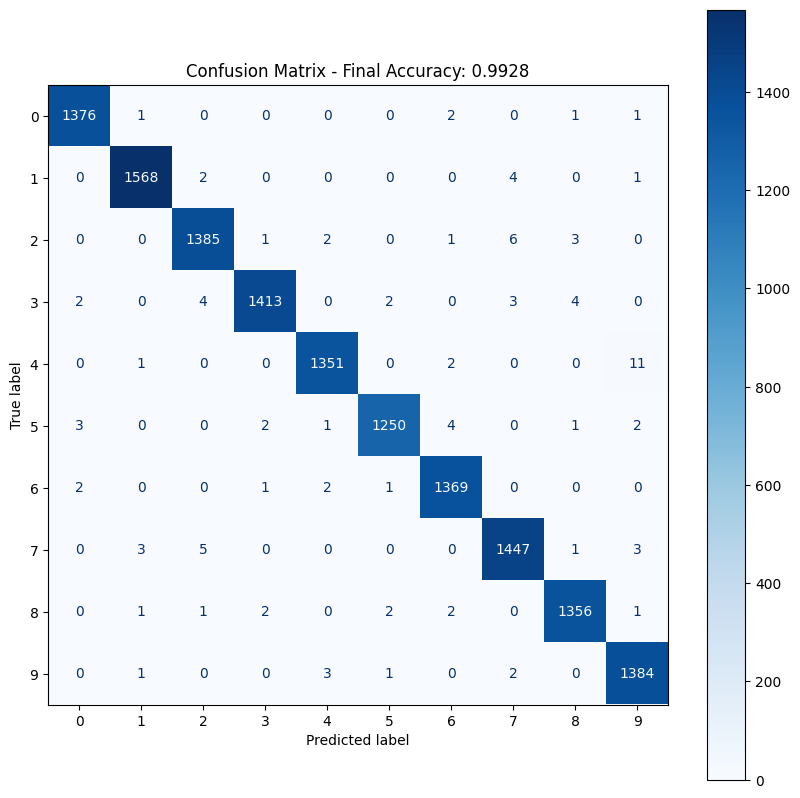


Analys av de svåraste fallen - 101 missar totalt:


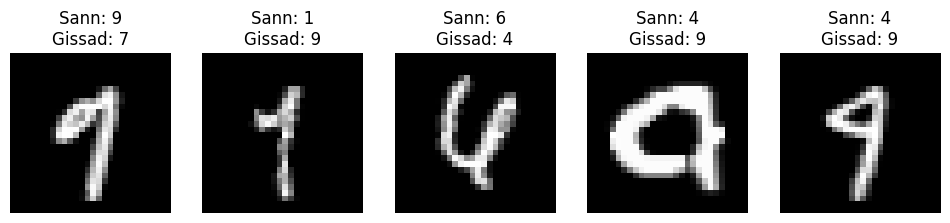

----------------------------------------
>>> Tid för denna slutträning: 41 minuter och 26 sekunder
>>> TOTAL TID FÖR HELA PROJEKTET: 50 minuter och 4 sekunder
----------------------------------------


In [ ]:
t0 = time.time()

# Träning på hela det augmenterade setet
final_pipe_ultra.fit(X_train_augmented, y_train_augmented)

# Nu kör vi mot testbilerna (som även de gått igenom deskew-processen
y_pred = final_pipe_ultra.predict(X_test_deskewed)
final_accuracy = final_pipe_ultra.score(X_test_deskewed, y_test)

# Resultat
print("="*60)
print("D E S K E W E D   U L T R A   -   S L U T G I L T I G   R A P P O R T")
print("="*60)
print(f"Modell: SVC (C=10, RBF) med PCA (112 komponenter)")
print(f"Träningsdata: {len(X_train_augmented)} rader (Deskewed + Augmented)")
print(f"Accuracy: {final_accuracy:.4f}")
print("-" * 60)

# Detaljerad statistik per siffra
print(classification_report(y_test, y_pred))

# Visualisera Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - Final Accuracy: {final_accuracy:.4f}")
plt.show()

# Visa exempel på felgissade bilder
mismatches = np.where(y_pred != y_test)[0]
if len(mismatches) > 0:
    print(f"\nAnalys av de svåraste fallen - {len(mismatches)} missar totalt:")
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(mismatches[:5]):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_test_deskewed[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Sann: {y_test[idx]}\nGissad: {y_pred[idx]}")
        plt.axis('off')
    plt.show()

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")



De där bilderna var inte vackra. Det är nu bara 101 felgissade bilder kvar, lika bra att kolla på alla.

Visar samtliga 101 felklassificeringar...


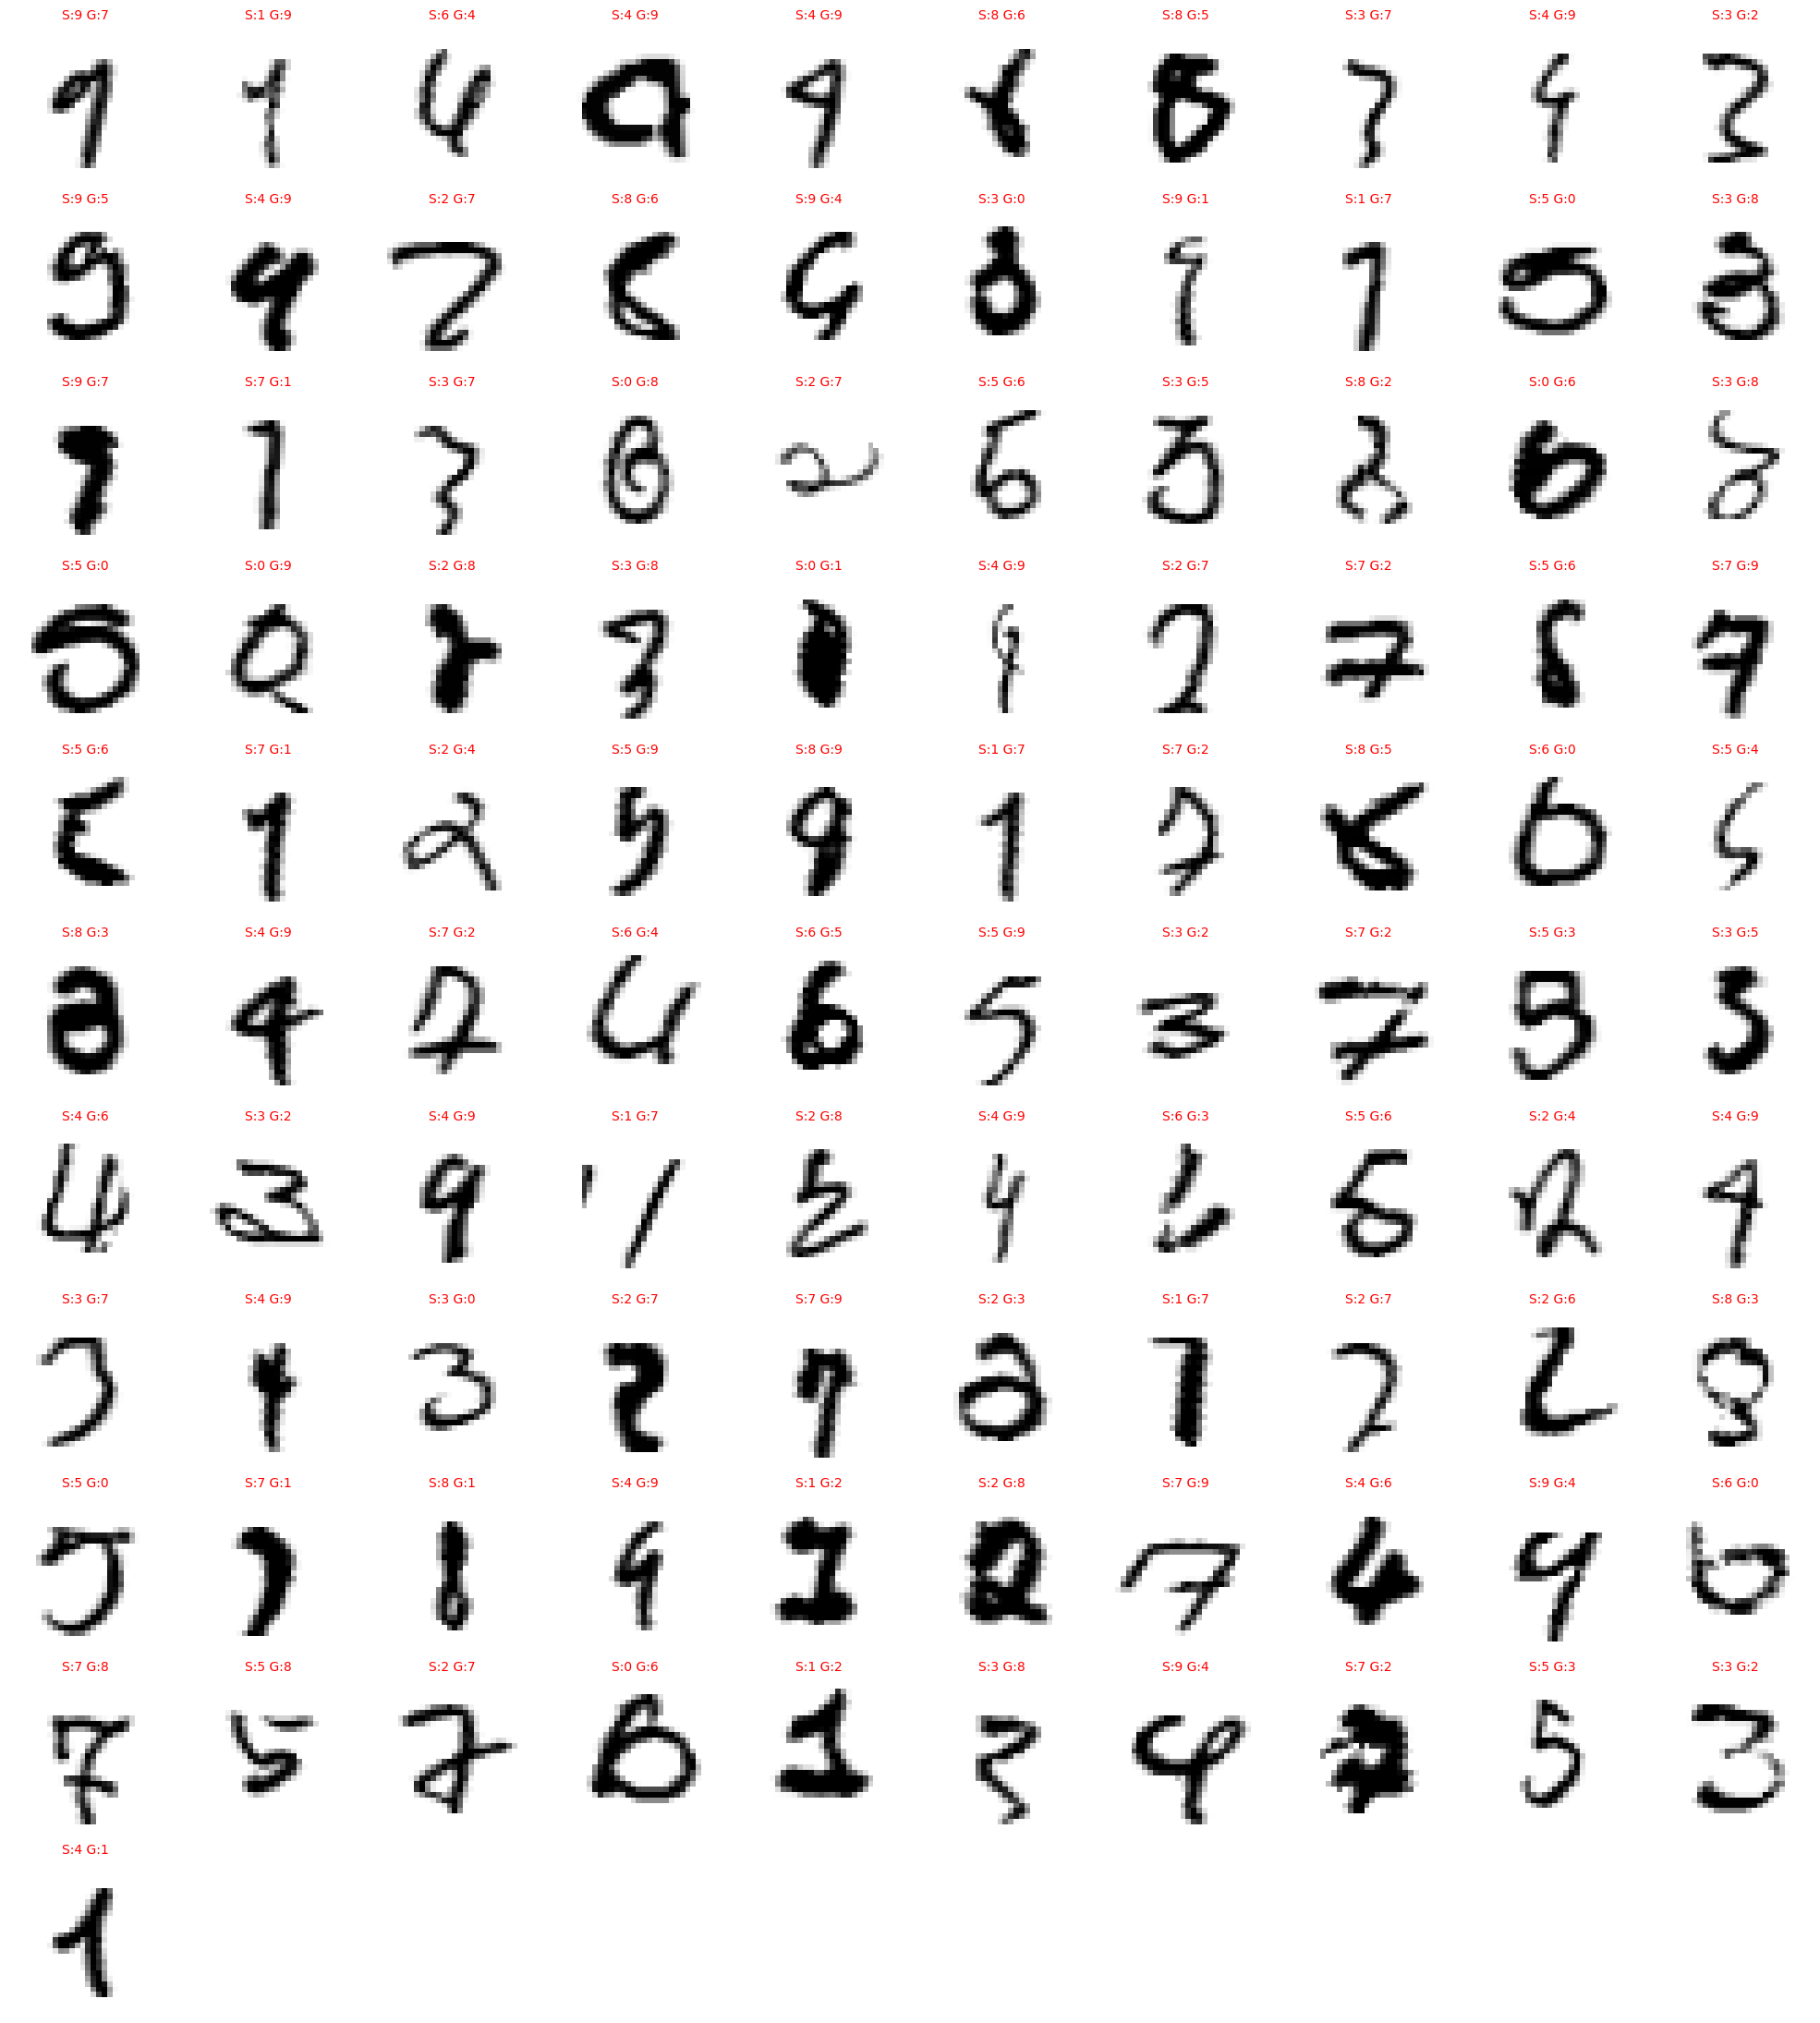

In [ ]:
import math

# 1. Hitta index för alla felklassificeringar
mismatches = np.where(y_pred != y_test)[0]
n_misses = len(mismatches)

# 2. Beräkna rader och kolumner (t.ex. 10x11 för 101 bilder)
cols = 10
rows = math.ceil(n_misses / cols)

print(f"Här är alla {n_misses} bilder som modellen gissat fel på.")
plt.figure(figsize=(20, 2 * rows))

for i, idx in enumerate(mismatches):
    plt.subplot(rows, cols, i + 1)
    # Bilderna som visas är upprätade (deskewed) eftersom det ju är dem modellen fått se
    plt.imshow(X_test_deskewed[idx].reshape(28, 28), cmap='gray_r')
    plt.title(f"S:{y_test[idx]} G:{y_pred[idx]}", fontsize=10, 
              color='red' if y_test[idx] != y_pred[idx] else 'black')
    plt.axis('off')

plt.tight_layout()
plt.show()

OK. Om ingen i klassen levererar betydligt bättre accuracy-siffror än mina så får det räcka här. 

På temat, "Don't let better be the enemy of good". 

In [17]:
joblib.dump(final_pipe_ultra, 'mnist_svc_deskew_agument_model.joblib')

['mnist_svc_deskew_agument_model.joblib']

# En annan approach till de felgissade bilderna

Jag tänker mig att jag skulle kunna bearbeta de nya bilder som modellen får se (testdata eller ritad/uppladdad bild), analysera dem separat och sedan låta prediktionen styras av ett majoritetsbeslut. Detta ska att döma av vad jag hittat online heta Test-Time Augmentation (TTA). D.v.s. augmentering av testdata.

In [18]:
t0 = time.time()

rescued = 0
still_wrong = 0

# TTA-motor som skapar 20 varianter med små geometriska transformationer. 
# Därefter får modellen analysera dem och fatta ett majoritetsbeslut.
def tta_predict(image_flat, model_pipeline, n_variants=20):
    variants = [image_flat]
    img_2d = image_flat.reshape(28, 28)
    
    for _ in range(n_variants - 1):
        angle = np.random.uniform(-4, 4)
        dx, dy = np.random.uniform(-0.8, 0.8, size=2)
        
        # Rotera och skifta varianten
        v = ndimage.rotate(img_2d, angle, reshape=False, order=1, mode='constant', cval=0)
        v = ndimage.shift(v, [dy, dx], mode='constant', cval=0)
        variants.append(v.flatten())
    
    # Prediktera alla varianter på en gång
    all_preds = model_pipeline.predict(np.array(variants))
    
    # Räkna röster och hitta vinnaren (mode)
    counts = np.bincount(all_preds)
    final_vote = np.argmax(counts)
    
    return final_vote

# Analys
print(f"Analyserar de {len(mismatches)} felgissade bilderna med Test-Time Augmentation (TTA).")
print("-" * 60)

for idx in mismatches:
    true_label = y_test[idx]
    
    # The jury is out!
    tta_vote = tta_predict(X_test_deskewed[idx], final_pipe_ultra, n_variants=20)
    
    if tta_vote == true_label:
        rescued += 1
    else:
        still_wrong += 1

# Resultat
new_accuracy = (14000 - still_wrong) / 14000

print("\n" + "="*60)
print("Slutgiltig utvärdering med TTA")
print("="*60)
print(f"Antal räddade bilder:      {rescued}")
print(f"Antal hopplösa fall:       {still_wrong}")
print(f"Accuracy före TTA:         0.9928")
print(f"Accuracy efter TTA:        {new_accuracy:.4f}")

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 60)
print(f">>> Tid för TTA-experimentet: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

Analyserar de 101 felgissade bilderna med Test-Time Augmentation (TTA).
------------------------------------------------------------

Slutgiltig utvärdering med TTA
Antal räddade bilder:      9
Antal hopplösa fall:       92
Accuracy före TTA:         0.9928
Accuracy efter TTA:        0.9934
------------------------------------------------------------
>>> Tid för TTA-experimentet: 7.0 sekunder
>>> Total tid sedan start: 1267 minuter och 23 sekunder
